# **競賽說明**

本次的項目是要預測句子所帶有的情緒.<br>

本次項目為NLP–單一文本多元分類任務<br>

競賽網址:<br>
https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews/overview

## **kernel架構:**

1. 讀取套件及載入資料
2. EDA 
3. Data Preprocessing(資料前處理) 
4. 模型建構 

問題思考和想法:<br>

- x

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip


# **1. 讀取套件及載入資料**

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

#skleran
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#transformers 
from transformers import RobertaTokenizer
from transformers import TFRobertaModel

#tensorflow
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical,plot_model 
#from keras.models import Sequential
#from keras.layers import Dense,Activation,Dropout
import keras_tuner as kt

#other
#import missingno as msno
from IPython.display import clear_output

In [3]:
#tsv檔的間隔符與csv檔不同
#此處讀取檔案時需修改參數sep(間隔符)值
train=pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip',sep='\t')
test=pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip',sep='\t')

# **2. EDA**

## **2.1 資料概述**

In [4]:
print(train.info())
train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB
None


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [5]:
print(test.info())
test.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PhraseId    66292 non-null  int64 
 1   SentenceId  66292 non-null  int64 
 2   Phrase      66292 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.5+ MB
None


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
5,156066,8545,intermittently pleasing but
6,156067,8545,intermittently pleasing
7,156068,8545,intermittently
8,156069,8545,pleasing
9,156070,8545,but


## **2.2 Columns**

- `PhraseId` : dataset序列. 鍵值.<br>
- `SentenceId` : 針對句子產生的序列編號.<br>
- `Phrase` : 文本資料.<br>
- `Sentiment` : 表示文本所帶有的情緒.只有traindata有這個列.<br>

在本次的項目當中<br>
將需要預測testdata的句子(Phrase)所帶有的情緒.<br>

In [6]:
#顯示資料的columns

print(f'''
traindata columns :
{train.columns}
數量 : {len(train.columns)}

testdata columns :
{test.columns}
數量 : {len(test.columns)}
''')


traindata columns :
Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')
數量 : 4

testdata columns :
Index(['PhraseId', 'SentenceId', 'Phrase'], dtype='object')
數量 : 3



### **2.2.1 PhraseId**

PhraseId為dataset的鍵值.


### **2.2.2 SentenceId**

SentenceId用於分類PharseId是屬於出自哪個序號的句子.<br>
經觀察後發現<br>
每個SentenceId除了包含最初始完整的句子<br>
同時也包含了同個SentenceId經過切割劃分的句子片段<br>
因此同時會有數筆資料屬於同個SentenceId.<br>

In [7]:

#顯示個別SentenceId和
#以及其原始未經過切割的文本
print('SentenceId and Pharase:')
for n in range(1,11):
    n=train[train['SentenceId']==n][['SentenceId','Phrase']].values[0][0]
    m=train[train['SentenceId']==n][['SentenceId','Phrase']].values[0][1]
    #print()
    print('-'*20)
    print(f'[{n}]',m)

#任意顯示某個SentenceId的資料
train[train['SentenceId']==3]
    

SentenceId and Pharase:
--------------------
[1] A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .
--------------------
[2] This quiet , introspective and entertaining independent is worth seeking .
--------------------
[3] Even fans of Ismail Merchant 's work , I suspect , would have a hard time sitting through this one .
--------------------
[4] A positively thrilling combination of ethnography and all the intrigue , betrayal , deceit and murder of a Shakespearean tragedy or a juicy soap opera .
--------------------
[5] Aggressive self-glorification and a manipulative whitewash .
--------------------
[6] A comedy-drama of nearly epic proportions rooted in a sincere performance by the title character undergoing midlife crisis .
--------------------
[7] Narratively , Trouble Every Day is a plodding mess .
--------------------
[8] The Importance of B

,PhraseId,SentenceId,Phrase,Sentiment
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
82,83,3,Even fans of Ismail Merchant 's work,2
83,84,3,Even fans,2
84,85,3,Even,2
85,86,3,fans,3
86,87,3,of Ismail Merchant 's work,2
87,88,3,Ismail Merchant 's work,2
88,89,3,Ismail Merchant 's,2
89,90,3,Ismail,2
90,91,3,Merchant 's,2


### **2.2.3 Phrase**

Phrase為文本<br>
包含了每個SentenceId的完整句子<br>
以及切割後的片段<br>

資料當中<br>
包含了非常多原始句子擷取的片段<br>
這些被拆解的片段雖然不能用於表示原始句子的語意和情緒<br>
不過作為模型訓練的data仍然是有價值的<br>
或許這樣可以當作擴充訓練資料集的方法之一.<br>
因此<br>
會將所有的資料都帶入模型當中做訓練.<br>

思考問題和想法:<br>
- 我想試著要抓出每個sentence完整的句子<br>
用的方法是從每個SentenceId抓出第一筆資料.<br>
那如果完整的句子不是第一筆呢?<br>
測試後發現<br>
有些SentenceId確實第一筆資料不是完整的句子<br>
而若是以抓出字數最多的當作完整句子
這樣的方法經測試後發現似乎會比較好.

In [8]:
#挑出任意一個句子出來比對

print('SentenceId 16 原始句子:')
print(train[train['SentenceId']==16]['Phrase'].values[0])

print('')
train[train['SentenceId']==16]

SentenceId 16 原始句子:
A welcome relief from baseball movies that try too hard to be mythic , this one is a sweet and modest and ultimately winning story .



,PhraseId,SentenceId,Phrase,Sentiment
423,424,16,A welcome relief from baseball movies that try...,3
424,425,16,A welcome relief from baseball movies that try...,3
425,426,16,A welcome relief,3
426,427,16,welcome relief,3
427,428,16,welcome,2
428,429,16,relief,2
429,430,16,from baseball movies that try too hard to be m...,1
430,431,16,baseball movies that try too hard to be mythic,0
431,432,16,baseball movies,2
432,433,16,baseball,2


### **2.2.4 Sentiment**

Semtiment用於表示文本所帶有的情緒.<br>
test dataset沒有這個column<br>
而train dataset則有這個column.<br>
在本次的項目當中將會預測test dataset是屬於哪個Semtiment值<br>
Semtiment會作為模型的Y值.<br>

其值的含意:<br>
0 - negative<br>
1 - somewhat negative<br>
2 - neutral<br>
3 - somewhat positive<br>
4 - positive<br>

In [9]:
print('Sentiment值以及其數量:')
train['Sentiment'].value_counts().sort_index()

Sentiment值以及其數量:


0     7072
1    27273
2    79582
3    32927
4     9206
Name: Sentiment, dtype: int64

# **3. Data Preprocessing(資料前處理)**

將資料轉換成模型輸入的格式.<br>

資料沒有缺失值.<br>

思考問題和想法:<br>
- 也許可以嘗試看看不同的配置名稱.<br>
- 也許可以試試不同的語言模型<br>
並且了解他們的差異.<br>
- 如果語言模型遇到語料庫中沒有的詞會怎麼辦?<br>

In [10]:
#

max_length=80
PRETRAINED_MODEL_NAME='roberta-base'

## **載入語言模型**

In [11]:
tokenizer=RobertaTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
test_text=train.iloc[0]['Phrase']
clear_output()

#tokenizer其中10個tokens對應ids
print('-'*20)
for n in np.random.randint(0,len(tokenizer.get_vocab()),10):
    n=list(tokenizer.get_vocab().keys())[n] 
    print('{0:15}{1:1}'.format(n,tokenizer.get_vocab()[n]))

print('-'*20)
print('tokenizer轉換測試:')
print(test_text)
print(tokenizer.encode(test_text))
print(tokenizer.convert_ids_to_tokens(tokenizer.encode(test_text)))

--------------------
osate          47357
Remote         46866
hol            9649
Ġlimit         3000
ĠVerb          38132
Ġpurity        32195
rench          18723
Ġlinguistic    39608
[_             49895
Ġcoffers       27342
--------------------
tokenizer轉換測試:
A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .
[0, 250, 651, 9, 11363, 1115, 4216, 16987, 5, 2329, 1580, 14, 99, 16, 205, 13, 5, 29910, 16, 67, 205, 13, 5, 821, 6072, 2156, 103, 9, 61, 10930, 524, 9764, 53, 4146, 9, 61, 5353, 7, 203, 9, 10, 527, 479, 2]
['<s>', 'A', 'Ġseries', 'Ġof', 'Ġesc', 'ap', 'ades', 'Ġdemonstrating', 'Ġthe', 'Ġad', 'age', 'Ġthat', 'Ġwhat', 'Ġis', 'Ġgood', 'Ġfor', 'Ġthe', 'Ġgoose', 'Ġis', 'Ġalso', 'Ġgood', 'Ġfor', 'Ġthe', 'Ġg', 'ander', 'Ġ,', 'Ġsome', 'Ġof', 'Ġwhich', 'Ġoccasionally', 'Ġam', 'uses', 'Ġbut', 'Ġnone', 'Ġof', 'Ġwhich', 'Ġamounts', 'Ġto', 'Ġmuch', 'Ġof

In [12]:
%%time
#觀察文本轉換後的各別token總數

tokens=[]
for n in range(len(train['Phrase'])):
    n=tokenizer.encode(train['Phrase'][n])
    tokens.append(n)   
#len(tokens)

#可能會需要視覺化句子token數量
#這樣可以比較知道padding數值要設為多少
#這邊可以用隨機取樣的方式
for n in tokens[:10]:
    print(len(n), n[:20],'...')
    
max_seq_len = max([len(n) for n in tokens])
print('句子最大tokens數: ',max_seq_len)
    

44 [0, 250, 651, 9, 11363, 1115, 4216, 16987, 5, 2329, 1580, 14, 99, 16, 205, 13, 5, 29910, 16, 67] ...
19 [0, 250, 651, 9, 11363, 1115, 4216, 16987, 5, 2329, 1580, 14, 99, 16, 205, 13, 5, 29910, 2] ...
4 [0, 250, 651, 2] ...
3 [0, 250, 2] ...
3 [0, 22760, 2] ...
17 [0, 1116, 11363, 1115, 4216, 16987, 5, 2329, 1580, 14, 99, 16, 205, 13, 5, 29910, 2] ...
3 [0, 1116, 2] ...
15 [0, 41274, 4216, 16987, 5, 2329, 1580, 14, 99, 16, 205, 13, 5, 29910, 2] ...
4 [0, 41274, 4216, 2] ...
15 [0, 34084, 6031, 1295, 5, 2329, 1580, 14, 99, 16, 205, 13, 5, 29910, 2] ...
句子最大tokens數:  79
CPU times: user 31.1 s, sys: 93.5 ms, total: 31.2 s
Wall time: 31.3 s


## **轉換文本資料**

In [13]:
%time
#轉換資料成model的input

#bert encoder.
#定義轉換資料的函式
#此函式將會把dataset轉換成model input
def encode(data):
    
    input_ids=[]
    attention_masks=[]

    for n in range(len(data)):
        #tokenizer.encode_plus 參數:
        #max_length 指定被補足的token數量
        #truncation 設定是否刪除超過max_length數量的token 
        input=tokenizer.encode_plus(data.Phrase[n],
                                    add_special_tokens=True,
                                    padding='max_length',
                                    max_length=max_length,
                                    truncation=True,
                                    return_attention_mask=True,)

        input_ids.append(input['input_ids'])
        attention_masks.append(input['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)
        
#轉換資料        
input_ids, attention_masks=encode(train)
test_input_ids, test_attention_masks=encode(test)

#顯示處理後的資料
#model input
print('input_ids:')
for n in range(10):
    print(input_ids[n][:20],'...')
print('attention_masks:')
for n in range(10):
    print(attention_masks[n][:20],'...')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
input_ids:
[    0   250   651     9 11363  1115  4216 16987     5  2329  1580    14
    99    16   205    13     5 29910    16    67] ...
[    0   250   651     9 11363  1115  4216 16987     5  2329  1580    14
    99    16   205    13     5 29910     2     1] ...
[  0 250 651   2   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1] ...
[  0 250   2   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1] ...
[    0 22760     2     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1] ...
[    0  1116 11363  1115  4216 16987     5  2329  1580    14    99    16
   205    13     5 29910     2     1     1     1] ...
[   0 1116    2    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1] ...
[    0 41274  4216 16987     5  2329  1580    14    99    16   205    13
     5 29910     2     1     1     1     1     1] ...
[    0 41

# **4. Model**

在預訓練模型使用的選擇上<br>
最初選擇使用BERT<br>
在testdata準確度約為0.64<br>
後來使用Roberta發現其具有更高的準確度<br>
變直接改用Roberta<br>
testdata準確度約為0.695.<br>

改善想法:
- 最後可加入confusion_matrix<br>
- 嘗試用不同的預訓練模型<br>
- 嘗試用不同的訓練配置<br>

思考問題和想法:
- 看這裡面有沒有可以用於改善model的想法<br>
概念篇 https://www.youtube.com/watch?v=xki61j7z-30&list=PLJV_el3uVTsPy9oCRY30oBPNLCo89yu49&index=16<br>
實作篇 https://www.youtube.com/watch?v=Ky1ku1miDow&list=PLJV_el3uVTsPy9oCRY30oBPNLCo89yu49&index=20<br>
- 我想把batch_sizes設定為1000做訓練<br>
不過出現錯誤了<br>
`ResourceExhaustedError : OOM when allocating ...`<br>
`failed to allocate memory`<br>
這是為甚麼?<br>
原因是記憶體不夠用了<br>
那其他更細節的原因呢?<br>
keras好像有一個可以清除緩存的代碼<br>
這有辦法提升batch_sizes的值嗎?<br>
- 一次把所有資料帶進去訓練<br>
batech_sizes設定為100<br>
每個epochs時間要20分鐘.<br>
如果希望減少訓練時間而減少帶入模型的資料量<br>
怎樣的資料量是比較剛好的?<br>
資料量和訓練時間之間會呈現甚麼關係?<br>
- 模型會把資料分批帶入做訓練<br>
那在不同的epoch中<br>
這些分批的資料會是一樣的嗎?<br>
model.fit()有打亂data的參數設定.<br>
是否一樣會影響訓練的結果嗎?<br>
- batch_sizes不應該設太大<br>
因為會讓訓練的結果不好.<br>
其中的原因改怎麼解釋?<br>
- 在這次的模型訓練當中<br>
第二輪以後val準確度便沒有再提升<br>
這個狀況在之前項目中也有出現.<br>
該怎麼理解這個狀況?<br>
如果某輪訓練沒有提升準確度<br>
那之後的訓練是否就不會再提升了?<br>
目前看起來通常是這樣<br>
因此會選在通常會選在val的準確沒有在提升時中斷訓練.<br>
- model.compile(Adam(lr=6e-6), loss='binary_crossentropy', metrics=['accuracy'])<br>
如果想提升訓練結果<br>
這邊是否能做某些調整?<br>
那還應該做甚麼調整?<br>
我能透過dropout提高val data的表現嗎?<br>
是否要提高BERT model中的dropout的比例才有用?<br>
adam和loss這兩個參數該怎麼解釋?<br>
- 如果有A model和 B model<br>
A model有20個layers<br>
B model有50個layers<br>
那A model可以做到的事情(準確度夠高)<br>
B model自然也可以做到.<br>
那如果B model沒辦法有差不多的準確度<br>
這可能代表model沒有訓練好.<br>
- 如果模型的準確度不高<br>
可能會是甚麼問題?<br>
模型沒有訓練好.<br>
模型參數不夠多(架構不對、不夠複雜,這邊在說的都是同一個狀況).<br>
https://www.youtube.com/watch?v=xki61j7z-30&list=PLJV_el3uVTsPy9oCRY30oBPNLCo89yu49&index=16<br>
- 透過relu可以改善前面的隱藏層訓練不夠的問題<br>
- neruel的數量可以理解為input轉換後的數量嗎?<br>
可以視為feature的維度轉換<br>
看起來是可以這樣理解.<br>
- max pooling是甚麼?<br>
匯總某個範圍內的值<br>
並提取最大的值當作這個區域的代表值<br>
- maxout network這樣的概念用在模型裡面會有甚麼效果?<br>
maxout就是max pooling<br>
https://youtu.be/xki61j7z-30?t=1512<br>
- neruel輸出值的正負有甚麼涵義嗎?<br>
- 是否可以視覺化loss值<br>
以了解模型訓練的狀況(plateau saddle,point,local minima)?<br>
- adam該怎麼定義他?<br>
有甚麼情況是會選擇不用adam的?<br>
- 我該如何知道訓練用的資料是否會超出記憶體?<br>
- 超參數比對工具:<br>
https://ithelp.ithome.com.tw/articles/10265801<br>
- 預訓練模型還有很多隱藏層<br>
我應該怎麼顯示出來?<br>
- 在訓練模型時<br>
常常出現模型沒辦法好好呈現訓練結果的狀況<br>
猜測應該是跟模型沒有初始化有關係<br>
這方面我應該透過甚麼操作來改善?<br>
- 出現了把資料全部都預測為中性<br>
而卻擁有44%準確度的狀況<br>
這該怎麼改善<br>
- tuner和模型訓練都會有參數沒有重置的問題<br>
讓不同模型訓練測試的準確度無法正確呈現<br>
這該怎麼改善?<br>
- 如果想要改善結果預測的準確度<br>
該怎麼做?<br>
模型調整?<br>
檢查資料的品質?<br>
資料篩選?<br>
檢查資料標記的狀況?<br>
重新整理出資料類別數比較平均的dataset?<br>

In [14]:
#模型相關定義及超參數

x=[input_ids,attention_masks]
y=to_categorical(train[['Sentiment']],num_classes=5)
test_x=[test_input_ids, test_attention_masks]


## **Transformers預訓練模型引入**

In [15]:
#預訓練模型載入

pretrained_model = TFRobertaModel.from_pretrained(PRETRAINED_MODEL_NAME)

#顯示bertmodel配置
print('-'*20)
print(pretrained_model.config)

#顯示bertmodel 選定的隱藏層的配置
#bertmodel1.layers[n].get_config()
# bertmodel1.layers[0].get_config()

#顯示用bertmodel轉換後的值
# x1=tf.convert_to_tensor(input_ids)
# x2=tf.convert_to_tensor(attention_masks)
# bertmodel([x1,x2])

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

2022-07-21 03:54:01.973405: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 03:54:01.974536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 03:54:01.975211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 03:54:01.976047: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

--------------------
RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



## **模型建構**

### **model**

In [16]:
#模型2

def create_model(bertmodel):

    #模型架構
    
    ids = tf.keras.Input(shape=(80,),dtype='int64')
    masks = tf.keras.Input(shape=(80,),dtype='int64')
    input=[ids,masks]
    
    output=bertmodel([ids,masks])#輸出應該是word embedding. 
    output=output[1]
    output=tf.keras.layers.Dense(272,activation='relu')(output)
    output=tf.keras.layers.Dropout(0.5)(output)
    output=tf.keras.layers.Dense(5, activation='sigmoid')(output)   

    model=tf.keras.models.Model(inputs = input,outputs = output)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model
    

model=create_model(pretrained_model)
model.summary()

#可以用下面方法直接修改模型
#model.optimizer.learning_rate=1e-5

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 272)          209168      tf_roberta_model[0][1]       

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [17]:
#配置1
#沒有另外加入dense層
#lr=6e-6
#_______________
# loss: [0.31026434898376465, 0.2714189887046814, 0.25940003991127014, 0.24948574602603912]
# accuracy: [0.6403947472572327, 0.6900631189346313, 0.7071478962898254, 0.720980703830719]
# val_loss: [0.27679771184921265, 0.27402064204216003, 0.273803174495697, 0.2746005654335022]
# val_accuracy: [0.6743560433387756, 0.6744201183319092, 0.6771113872528076, 0.6762783527374268]
# test_accuracy: 0.69

#配置2
#加一dense層,units為272
#lr=1.7e-5
#____________________________________
# loss: [0.30388250946998596, 0.26689261198043823, 0.2496534138917923]
# accuracy: [0.6529379487037659, 0.7017573118209839, 0.7267317175865173]
# val_loss: [0.27894818782806396, 0.2798663377761841, 0.28203070163726807]
# val_accuracy: [0.6689093708992004, 0.6692298054695129, 0.6747725009918213]
# test_accuracy:0.69984

#配置3
#加一dense層,units為272
#lr=1e-5
#____________________________________
# loss: [0.31148579716682434, 0.2726139426231384, 0.2576909363269806, 0.24586567282676697, 0.2348412424325943, 0.22628311812877655]
# accuracy: [0.6437267661094666, 0.6964468955993652, 0.7175846099853516, 0.7331875562667847, 0.7488706111907959, 0.7602925300598145]
# val_loss: [0.2784871459007263, 0.2730500400066376, 0.2769792079925537, 0.2866998314857483, 0.28758808970451355, 0.2922053039073944]
# val_accuracy: [0.6743239760398865, 0.6774317622184753, 0.6782968044281006, 0.6605471968650818, 0.6702870726585388, 0.6630462408065796]
# test_accuracy:0.69634

## **測試keras_tuner**

這個段落用於測試keras_tuner(kt)<br>
用於搜尋找表現更好的模型超參數.<br>
在本次的項目當中已經有嘗試利用其尋找超參數<br>
並將找到的超參數帶入到模型中<br>
不過模型的建立並不是透過kt語法直接完成的<br>
因此這個段落在閱讀上可以選擇直接跳過.<br>

在反覆操作下<br>
我發現我對於keras_tuner仍然不是很熟悉<br>
不確定該如何找出想找的最佳參數<br>
還必須再花時間研究.<br>

參考:<br>
https://keras.io/keras_tuner/<br>
https://ithelp.ithome.com.tw/articles/10265801<br>

In [18]:
def model_tuner(lr,bertmodel):   
    #模型架構

    ids = tf.keras.Input(shape=(80,),dtype='int64')
    masks = tf.keras.Input(shape=(80,),dtype='int64')
    input=[ids,masks]

    output=bertmodel([ids,masks])#輸出應該是word embedding. 
    output=output[1]
    output=tf.keras.layers.Dense(272,activation='relu')(output)
    output=tf.keras.layers.Dropout(0.45)(output)
    output=tf.keras.layers.Dense(5, activation='sigmoid')(output)   

    model=tf.keras.models.Model(inputs = input,outputs = output)
    #此處我原本想用SparseCategoricalCrossentropy(sparse_categorical_crossentropy)
    #不過會在之後.seach()(同fit)部分出現錯誤
    #原因是為甚麼?
    #https://stackoverflow.com/questions/49161174/tensorflow-logits-and-labels-must-have-the-same-first-dimension/62286888#62286888
    #應該是這樣
    #SparseCategoricalCrossentropy是用於數字序列分類的案例
    #而在這次的案例當中
    #則是以one_hot做分類
    #因此會出現錯誤.
    model.compile(Adam(lr=lr), loss='CategoricalCrossentropy', metrics=['accuracy']) 
    
    return model

#新增要搜尋的超參數至hp中
#並建立model
def build_model(hp):
    #units = hp.Int("units", min_value=32, max_value=512, step=120) #找units數
    #dorate=hp.Float('dorate', min_value=0.1, max_value=1, sampling="log")
    lr = hp.Float("lr", min_value=1e-6, max_value=1e-2, sampling="log")
    model0=model_tuner(lr,bertmodel=pretrained_model)
    
    return model0
#參考
# def build_model(hp):
#     units = hp.Int("units", min_value=32, max_value=512, step=32)
#     activation = hp.Choice("activation", ["relu", "tanh"])
#     dropout = hp.Boolean("dropout")
#     lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
#     # call existing model-building code with the hyperparameter values.
#     model = call_existing_code(
#         units=units, activation=activation, dropout=dropout, lr=lr
#     )
#     return model


#確認模型架構
build_model(kt.HyperParameters()).summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 272)          209168      tf_roberta_model[1][1]     

In [19]:
#暫時沒用
# x=kt.HyperParameters()
# dorate=x.Float('dorate', min_value=0.1, max_value=1, sampling="log")
# lr = x.Float("lr", min_value=1e-6, max_value=1e-2, sampling="log")
# #kt.HyperParameters().values

In [20]:
#定義調節器(模型超參數調節器)
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',#可設定為val_loss.當Data數比較小時,或許用loss當作指標可能會比較好
    max_trials=5,
    #executions_per_trial=2,
    #不知道怎麼查看這些檔案
    #應該可以嘗試從TF儲存模型和參數這塊去理解
    #directory='./',
    #project_name='test'
)

#查看超參數搜索空間及項目
tuner.search_space_summary()

Search space summary
Default search space size: 1
lr (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [21]:
#抓取指定數量的隨機資料
rate=0.01
sample=np.random.randint(0,len(x[0]),size=round(rate*len(x[0])))
x1=[x[0][sample],x[1][sample]]
y1=y[sample]

print(x1[0].shape)
print(y1.shape)


#搜索超參數.
#.seach()的api有點難以理解阿
#似乎跟model.fit()有類似的用法
#這部分要再另外花時間理解.
# print('-'*30)
# tuner.search(x1,
#              y1,
#              validation_split=0.2,
#              epochs=4,
#              batch_size=100)  
# #顯示搜尋解果
# tuner.results_summary()

#tuner相關問題:
#-我要如何看曾經使用過的超參數以及對應準確度?
#-有辦法看到選擇的超參數每個epoch的訓練狀況嗎?
#-epoch不夠而導致欠擬合是否有可能讓模型無法正確反映準確度?
#-tuner.seach()似乎會調整到原本的模型,為甚麼?

(1561, 80)
(1561, 5)


In [22]:
#兩種方法利用tuner建立找到的最佳參數的模型.

#-方法一
#提取最佳參數重新建立一個模型.
# best_hps = tuner.get_best_hyperparameters(5) #參數值5代表選取前五個表現最好的參數值,這個值設為多少或許不是那麼重要
#Build the model with the best hp.
# model = build_model(best_hps[0])
# model.summary()

#-方法二 #無法執行
#直接透過tuner建立.
# Get the top 2 models.
#models = tuner.get_best_models(num_models=2)

# best_model = models[0]
# best_model.summary()

## **訓練**

In [23]:
#抓取指定數量的隨機資料

# rate=0.01
# sample=np.random.randint(0,len(x[0]),size=round(rate*len(x[0])))
# x1=[x[0][sample],x[1][sample]]
# y1=y[sample]

# print(x1[0].shape)
# print(y1.shape)

In [24]:
%%time

#checkpath相關參考下面:
#https://www.tensorflow.org/tutorials/keras/save_and_load.
#檔案格式是甚麼?ckpt?h5?
#取決與.ModelCheckpoint()參數save_weights_only
#存模型,格式為h5
#單純存參數,格視為ckpt

#設定checkpoint
#保存準確度最佳的model.
checkpoint_path = "./cp_best.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint= tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    #參數save_weights_only將決定檔名應該要用甚麼格式.
    # save_weights_only=True
)

#訓練模型
history = model.fit(
    x,
    y,
    validation_split=0.2,
    epochs=4,
    callbacks=[checkpoint],
    batch_size=100)

#載入最佳模型
#1.
model.load_weights('./cp_best.h5')
#or
#2.
# model.load_weights('./cp_test.ckpt')


2022-07-21 03:54:19.991902: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/4
1249/1249 [==============================] - 1193s 944ms/step - loss: 0.3131 - accuracy: 0.6437 - val_loss: 0.2828 - val_accuracy: 0.6668

Epoch 00001: val_loss improved from inf to 0.28283, saving model to ./cp_best.h5
Epoch 2/4
1249/1249 [==============================] - 1177s 942ms/step - loss: 0.2735 - accuracy: 0.6951 - val_loss: 0.2849 - val_accuracy: 0.6582

Epoch 00002: val_loss did not improve from 0.28283
Epoch 3/4
1249/1249 [==============================] - 1177s 943ms/step - loss: 0.2586 - accuracy: 0.7160 - val_loss: 0.2796 - val_accuracy: 0.6730

Epoch 00003: val_loss improved from 0.28283 to 0.27957, saving model to ./cp_best.h5
Epoch 4/4
1249/1249 [==============================] - 1178s 943ms/step - loss: 0.2468 - accuracy: 0.7325 - val_loss: 0.2873 - val_accuracy: 0.6652

Epoch 00004: val_loss did not improve from 0.27957
CPU times: user 51min 3s, sys: 5min 32s, total: 56min 36s
Wall time: 1h 19min 36s


In [25]:
print('-'*30)
print('model')
for n in history.history:
    print('{}: {}'.format(n,history.history[n]))

------------------------------
model
loss: [0.31305816769599915, 0.2735230624675751, 0.25861334800720215, 0.24684391915798187]
accuracy: [0.643662691116333, 0.6950691938400269, 0.7159666419029236, 0.7325307726860046]
val_loss: [0.2828330397605896, 0.2849234342575073, 0.27957284450531006, 0.2872771620750427]
val_accuracy: [0.6668268442153931, 0.6581763625144958, 0.6729783415794373, 0.6652249097824097]


In [26]:
#顯示train data預測結果

pred_y=model.predict(x)
pred_y=pred_y.argmax(1) 
print('pred_y:')
print(pred_y)

print('-'*30)
num=0
start=7000
for n,m in zip(pred_y[start:],train['Phrase'].iloc[start:]):
    num+=1
    print(f'[{n}]',m)
    if num==10:
        break

pred_y:
[2 2 2 ... 2 2 2]
------------------------------
[2] for the back row
[2] the back row
[2] back row
[2] row
[0] , the dialogue sounds like horrible poetry .
[0] the dialogue sounds like horrible poetry .
[2] the dialogue
[0] sounds like horrible poetry .
[0] sounds like horrible poetry
[2] sounds


[[ 4015  2855   161    39     2]
 [ 2423 18533  5913   393    11]
 [  371  6960 65332  6722   197]
 [   16   457  7024 21402  4028]
 [    1    20   131  2862  6192]]


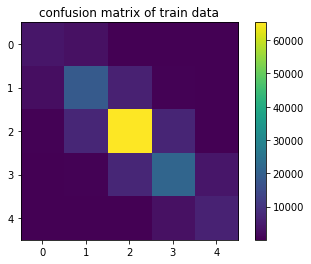

In [27]:
#混淆矩陣以及繪圖

#混淆矩陣
#https://honglung.pixnet.net/blog/post/214669413-%E6%B7%B7%E6%B7%86%E7%9F%A9%E9%99%A3
#左側代表正確label
#下側代表預測label
cm=confusion_matrix(train['Sentiment'],pred_y,labels=[0,1,2,3,4])
print(cm)

#視覺化
plt.imshow(cm)
plt.title('confusion matrix of train data')
plt.colorbar()

觀察:<br>
大多數資料的預測結果都沒有太嚴重的誤差<br>
這邊所謂的嚴重誤差<br>
指的像是正面的label被分類到負面的label<br>
被分類到完全不同意義的類別當中這樣的狀況.<br>
依照這樣的情況<br>
某方面來說<br>
應該可以認為模型至少可以區分兩個不同面向的情緒<br>
或許如果今天是以正負兩種情緒作為分類的類別<br>
那預測表現可能會不錯<br>
(如果直接在現有的模型中加一個二元分類的層是可行的嗎?)<br>

那至於如果要在更細分情緒的程度呢?<br>
看起來模型在這方面就會有比較大的誤差<br>
從預測結果可以發現到這樣的現象.<br>
以現實的狀況來看<br>
若現在是由人類來判斷情緒的程度<br>
個人認為也會存在非常多判斷的結果與實際不同的狀況<br>
因此模型會有這樣的現象是有可能的.<br>


如果想要改善結果預測的準確度<br>
該怎麼做?<br>
模型調整?<br>
檢查資料的品質?<br>
資料篩選?<br>
檢查資料標記的狀況?<br>
重新整理出資料類別數比較平均的dataset?<br>

## **提交test dataset預測結果**

In [28]:
#預測test dataset結果

test_y=model.predict(test_x)
print('test_y:')
print(test_y.argmax(1))

test_y:
[2 2 2 ... 1 1 2]


In [29]:
#預測的結果合併到test中
test['Sentiment']=test_y.argmax(1)

#挑選幾筆資料來查看.
#這邊可以修改為隨機取樣的方式來查看.
num=0
start=1000
for n,m in zip(test['Sentiment'].iloc[start:],test['Phrase'].iloc[start:]):
    num+=1
    print(f'[{n}]',m)
    if num==20:
        break

[1] defoliation
[2] of ego
[2] ego
[3] make the film touching despite some doldrums
[3] make the film touching
[2] make
[3] the film touching
[3] film touching
[3] touching
[2] despite some doldrums
[2] some doldrums
[2] some
[1] doldrums
[0] Imagine a really bad community theater production of West Side Story without the songs .
[0] Imagine a really bad community theater production of West Side Story without the songs
[0] Imagine a really bad community theater production of West Side Story
[2] Imagine
[0] a really bad community theater production of West Side Story
[0] a really bad community theater production
[0] really bad community theater production


In [30]:
#將預測結果合併至競賽提交格式

submission=pd.read_csv('../input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv')

submission['Sentiment']=test['Sentiment']
submission.to_csv('submission.csv',index=False)

#最終競賽提交格式

submission.head(10)

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2
5,156066,3
6,156067,3
7,156068,2
8,156069,3
9,156070,2


提交testdata預測結果後<br>
顯示準確度約為0.695.<br>